<a href="https://colab.research.google.com/github/Utkarsh2401/Enter_Darknet/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to train a Classifier on Cifar-10 using Darknet on Colab notebook using a Resnet model's config file.

## Welcome!

This Colab notebook will demonstrate how to:

* Train a **34-Layer Resnet** model using **Darknet** on the **Cifar-10 dataset** using the Colab **12GB-RAM GPU**.
* Turn Colab notebooks into an effective tool to work on real projects. 
  * Configure your notebook to install everything you need and start training in a few minutes. 
  * Store your trained weights directly on your computer or your drive so that you use the trained model whenever needed.
  * Convert a model from a graph to a .cfg file and pass it to darknet in order to train your dataset. (We  use a 34-layer resnet model with the Cifar-10 Dataset for object Classification, same mathod can be adapted for custom datasets and different models)
  * Check the accuracy of your model and print a graph to see the behaviour of the hyperparameters throughout the training


  #### This notebook is part of the github repo [Enter_Darknet](https://github.com/Utkarsh2401/Enter_Darknet) We encourage you to visit! You will find a deeper explanation along with the resources and references we used while understanding and exploring Darknet via colab.

  ---


  

## STEP 1. Configure runtime to work with GPU

We want to use the **12GB-RAM GPU** hardware acceleration!

Go to **> Menu > Runtime > Configure Runtime Type** And select **GPU** From the **Hardware accelerator** drop down menu.

---




## STEP 2. Check CUDA release version

Nvidia CUDA is pre-installed on Colab notebooks. Now we'll check the version installed.



In [1]:
# This cell can be commented once you checked the current CUDA version
# CUDA: Let's check that Nvidia CUDA is already pre-installed and which version is it. In some time from now maybe you 
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


---

## STEP 3. Installing Darknet
Great!! We have all the necessary to start working with Darknet. 

This notebook works with a slightly modified version of darknet, which is based on the [AlexeyAB Darknet repo](https://github.com/AlexeyAB/darknet/)

* To start, we will:
  * Clone and compile the darknet project.


In [2]:
!rm -rf darknet
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15316, done.
remote: Counting objects: 100% (15316/15316), done.
remote: Compressing objects: 100% (4581/4581), done.
remote: Total 15316 (delta 10408), reused 15315 (delta 10408), pack-reused 0
Receiving objects: 100% (15316/15316), 13.72 MiB | 18.01 MiB/s, done.
Resolving deltas: 100% (10408/10408), done.


In [20]:
cd darknet

/content/darknet


In [21]:
ls

3rdparty/               darknet_video.py        obj/
backup/                 data/                   README.md
build/                  image_yolov3.sh*        results/
build.ps1*              image_yolov4.sh*        scripts/
cfg/                    include/                src/
cmake/                  json_mjpeg_streams.sh*  vcpkg.json
CMakeLists.txt          LICENSE                 video_yolov3.sh*
DarknetConfig.cmake.in  Makefile                video_yolov4.sh*
darknet_images.py       net_cam_v3.sh*
darknet.py              net_cam_v4.sh*


## Change settings to use GPU

Remember to go to Makefile.txt in the darknet repository and make changes as follows

```
GPU=1  
CUDNN=1  
CUDNN_HALF=0  
OPENCV=1  
AVX=0  
OPENMP=0  
LIBSO=0  
ZED_CAMERA=0  
ZED_CAMERA_v2_8=0 
``` 

When compiling it, your output last line has to be something like this:

`g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU (...)`

In [22]:
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_opencv.cpp:1150:10: note: ...thi

---

## Step 4.Loading the dataset and Backup directory to store our weights

In [23]:
mkdir backup

mkdir: cannot create directory ‘backup’: File exists


In [24]:
cd data

/content/darknet/data


* Load the Cifar-10 dataset into the data folder of darknet
  * Clone it from the website

In [25]:
!wget https://pjreddie.com/media/files/cifar.tgz

--2021-10-24 03:50:13--  https://pjreddie.com/media/files/cifar.tgz
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168584360 (161M) [application/octet-stream]
Saving to: ‘cifar.tgz.1’

cifar.tgz.1         100%[===================>] 160.77M  55.6MB/s    in 2.9s    

2021-10-24 03:50:16 (55.6 MB/s) - ‘cifar.tgz.1’ saved [168584360/168584360]




* Unzip the files, and create the train.list and test.list files

In [26]:
!tar xzf cifar.tgz

In [27]:
cd cifar

/content/darknet/data/cifar


In [28]:
!find `pwd`/train -name \*.png > train.list

In [29]:
!find `pwd`/test -name \*.png > test.list

In [30]:
ls

labels.txt  test/  test.list  train/  train.list


---

## STEP 5. Preparing your data and configuration files 

Before going further let's take a look at what configuration files you need to have in your local drive _`darknet`_

![Yolov3 configuration files cheat sheet.jpg](http://blog.ibanyez.info/download/B20190410T000000072.png)

You can download the cheat sheet [here](http://blog.ibanyez.info/download/B20190410T000000072.png)

This gives a rough idea of how our .data and .cfg files work.


In [31]:
cd ../..

/content/darknet


In [32]:
cd cfg

/content/darknet/cfg


* Once in the cfg folder in the root darknet directory:
  * Click on the three dots and create a new file named cifar.data. Then double click on it and paste the ext below and then save it.

 ``` 
classes=10  
train  = data/cifar/train.list  
valid  = data/cifar/test.list  
labels = data/cifar/labels.txt  
backup = backup/  
top=2
```  

This is a classic .data file for the Cifar-10 dataset. It can be understood as follows:
* classes=10: the dataset has 10 different classes
* train = ...: where to find the list of training files
* valid = ...: where to find the list of validation files
* labels = ...: where to find the list of possible classes
* backup = ...: where to save backup weight files during training
* top = 2: calculate top-n accuracy at test time (in addition to top-1)

* Next we will create a .cfg file in the same way. We refer a 34 layer resnet model for this.
[34-layer resnet model ](http://blog.ibanyez.info/download/B20190410T000000072.png)
  * Similarly as above, create a resnet34.cfg file in the cfg folder in the darknet root directory, and copy paste the following contents into it.
  * This is the network we will be training.




```
[net]
# how many images are in each batch to average the loss over?
batch=32 
# into how many sub-batches shall each batch be divided to handle images in each sub-batch in parallel? 
subdivisions=1
height=28			#can adjust according to dataset
width=28
channels=3			#using rgb images
max_crop=32
min_crop=32

#parameters for data augmentation
hue=.1
saturation=.75
exposure=.75

#parameters for learning
learning_rate=0.1	
policy=poly
power=4
max_batches = 5000		#max number of iterations, corresponding to scale
momentum=0.9
decay=0.0005

[convolutional]			
batch_normalize=1     #purple 1
filters=64
size=7
stride=2
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]			
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky


[convolutional]			
batch_normalize=1     #purple 2
filters=64
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky


[convolutional]			
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky


[convolutional]			
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky

[convolutional]			
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky


[convolutional]			
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky


[convolutional]			
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky

[convolutional]		
batch_normalize=1
filters=256
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky

[convolutional]			
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky

[convolutional]			
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky

[convolutional]			
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky

[convolutional]			
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky

[convolutional]			
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky

[convolutional]			
batch_normalize=1
filters=512
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky

[convolutional]		
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky


[convolutional]			
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=linear

[shortcut]
from=-3
activation=leaky

[convolutional]
filters=10
size=1
stride=1
pad=1
activation=leaky

[avgpool]

[softmax]
```





Our model is inspired by the ‘Deep Residual Learning for Image Recognition’ research paper written by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun of Microsoft Research. 

* It has  34 convolutional layers with one max pooling layer and multiple shortcuts
* The last convolutional layer has 10 filters because we have 10 classes. It outputs a 7 x 7 x 10 image. 
* We just want 10 predictions total so we use an average pooling layer to take the average across the image for each channel. This will give us our 10 predictions. 
* We use a softmax to convert the predictions into a probability distribution. This layer also calculates our error as cross-entropy loss.

In [34]:
#Just check that we are in the correct location
!pwd

/content/darknet/cfg


In [35]:
#Ensure that the two new files we added are saved correctly
!ls

9k.labels				    rnn.train.cfg
9k.names				    strided.cfg
9k.tree					    t1.test.cfg
alexnet.cfg				    tiny.cfg
cd53paspp-gamma.cfg			    tiny-yolo.cfg
cifar.cfg				    tiny-yolo-voc.cfg
cifar.data				    tiny-yolo_xnor.cfg
cifar.test.cfg				    untitled
coco9k.map				    vgg-16.cfg
coco.data				    vgg-conv.cfg
coco.names				    voc.data
combine9k.data				    writing.cfg
crnn.train.cfg				    yolo.2.0.cfg
csdarknet53-omega.cfg			    yolo9000.cfg
cspx-p7-mish.cfg			    yolo.cfg
cspx-p7-mish_hp.cfg			    yolov1
cspx-p7-mish-omega.cfg			    yolov2.cfg
csresnext50-panet-spp.cfg		    yolov2-tiny.cfg
csresnext50-panet-spp-original-optimal.cfg  yolov2-tiny-voc.cfg
darknet19_448.cfg			    yolov2-voc.cfg
darknet19.cfg				    yolov3_5l.cfg
darknet53_448_xnor.cfg			    yolov3.cfg
darknet53.cfg				    yolov3.coco-giou-12.cfg
darknet.cfg				    yolov3-openimages.cfg
densenet201.cfg				    yolov3-spp.cfg
efficientnet_b0.cfg			    yolov3-tiny_3l.cfg
efficientnet-lite3.cfg			    yolov3-tiny.cfg
en

In [36]:
### Let us all make some util functions that we can use later


In [37]:
#utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()



---

## Step 6. Train the model 
When you execute the following command, your model will start training.

You will have a log line per epoch. On each iteration you will see how your training is going.

> **TRICK: Darknet copies a backup of your trained weights every 1000 iterations. It also stores the last weight file as cfg_filename_last.weights and the final correct weights file as 'cfg_filename'_final.weights. Once this is generated you should download this file and keep as now the model can be used even without training.


In [38]:
cd ..

/content/darknet


In [39]:
!pwd

/content/darknet


Streaming output truncated to the last 5000 lines.
2515, 1.610: 1.683659, 1.822805 avg, 0.006101 rate, 0.181859 seconds, 80480 images, 0.130513 hours left
Loaded: 0.000068 seconds
2516, 1.610: 1.636733, 1.804197 avg, 0.006092 rate, 0.190536 seconds, 80512 images, 0.130436 hours left
Loaded: 0.000056 seconds
2517, 1.611: 1.798869, 1.803665 avg, 0.006082 rate, 0.189863 seconds, 80544 images, 0.130380 hours left
Loaded: 0.000063 seconds
2518, 1.612: 2.120524, 1.835351 avg, 0.006072 rate, 0.191163 seconds, 80576 images, 0.130337 hours left
Loaded: 0.000060 seconds
2519, 1.612: 1.786284, 1.830444 avg, 0.006062 rate, 0.186402 seconds, 80608 images, 0.130245 hours left
Loaded: 0.000073 seconds
2520, 1.613: 2.040476, 1.851447 avg, 0.006052 rate, 0.189283 seconds, 80640 images, 0.130169 hours left
Loaded: 0.000081 seconds
2521, 1.613: 1.703221, 1.836625 avg, 0.006043 rate, 0.192981 seconds, 80672 images, 0.130110 hours left
Loaded: 0.000089 seconds
2522, 1.614: 1.743002, 1.827262 avg, 0.006033 

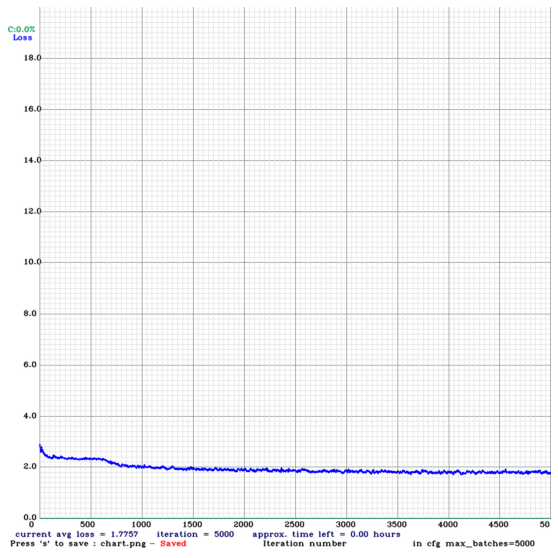

In [40]:
!./darknet classifier train cfg/cifar.data cfg/resnet34.cfg -dont_show
imShow("/content/darknet/chart_resnet34.png")

---

## Step 7 : Done, Congratulations, you have successfully trained the model!

Now, you can use the following command along with the weights file that was automatically saved in the conmtent/darknet/backup folder, or if you it saved seperately, you can upload it to the current notebook and specify the path relative to content/darknet.

#### Once the cell runs, you will be asked to provide an input image path, and you can then use the trained model to help classify your image as per Cifar's 10 classes.

In [42]:
!./darknet classifier predict cfg/cifar.data cfg/resnet34.cfg backup/resnet34_final.weights

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     64       7 x 7/ 2     28 x  28 x   3 ->   14 x  14 x  64 0.004 BF
   1 max                2x 2/ 2     14 x  14 x  64 ->    7 x   7 x  64 0.000 BF
   2 conv     64       3 x 3/ 1      7 x   7 x  64 ->    7 x   7 x  64 0.004 BF
   3 conv     64       3 x 3/ 1      7 x   7 x  64 ->    7 x   7 x  64 0.004 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs:   7 x   7 x  64 0.000 BF
   5 conv     64       3 x 3/ 1      7 x   7 x  64 ->    7 x   7 x  64 0.004 BF
   6 conv     64       3 x 3/ 1      7 x   7 x  64 ->    7 x   7 x  64 0.004 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs:   7 x   7 x  64 0.000 BF
   8 conv     64       3 x 3/

## PERFORMANCE TIPS & TRICKS

* **Speed up load times of the runtime:** When everything is checked that works, you can remove cells or comment unnecessary lines of code to make your loading time lower on every run. 
Also, once your model is trained, you can skip Step 6 completely, and provide the correct path to saved weights in Step 7

* **How to keep your notebook alive for more time?:** Keep you browser with your notebook open. If you close your browser, your notebook will reach the iddle time and will be removed from Colab cloud Service. (90 minutes)
  
* **Re-run your training after reaching the limitation time for Colab runtimes (12 hours):** 
  * Open a new notebook or reconnect the current one.
  * Comment the cell above and uncomment the cell below.
  * In your local computer, copy the file **backup/yolov3_last.weights** to your local computer **weights/** folder. 
  * Execute Run all in the **> menu > Runtime > Run All**
  * _The copy step is not absolutely necessary, but it is good to save the trouble of training the model again and again._